In [1]:
import scipy.sparse as ss
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import string
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import precision_recall_curve
from corextopic import corextopic as ct
import guidedlda

### Read Input Data

In [2]:
data=[]
with open('C:\\Users\\User\\Desktop\\isi\\il5_Tigrinya.txt',encoding='utf8',errors='ignore') as fp:
    for line in fp:
        data.append(line.split('\t'))
# name the columns of the datframe
raw_data = pd.DataFrame(data,columns=['doc_id','text_data','class_type']) 
# strip columns for leading and trailing white spaces
raw_data['doc_id']=raw_data.doc_id.str.strip()
raw_data['text_data']=raw_data.text_data.str.strip()
raw_data['class_type']=raw_data['class_type'].str.strip()
# n docs x m attributes
raw_data.shape
raw_data.head(2)

,doc_id,text_data,class_type
0,IL5_SN_000370_20170213_H0T00370Z,#Eritrea #ارتريا ባዓል ፈንቅል ኣብ ከተማ ሮተርዳም ፳፻፲፯ – ...,nondomain
1,IL5_WL_020506_20160616_H0040MDW3,ሰበ ስልጣን ስርዓት ኢህወደግ ኣብ ጐኒ ውድብ ብኣዴን ተሰሊፎም ንዝተቓለሱ...,unk


In [3]:
# set doc_id as index of the datframe
raw_data= raw_data.set_index('doc_id')
# change "class_type" column to "categorical" datatype
raw_data['class_type'] = raw_data['class_type'].astype('category')
#eval_incident - This should be considered as part of “indomain”
raw_data.loc[raw_data['class_type']=="eval_incident", 'class_type'] = "indomain"

### Data Pre-Processing

    - http links removal
    - RT (Retweet) keyword removal
    - Punctuation removal
    - Remove @names from tweets
    - Remove emoji's
    - Date Removal/Numbers removal
    - Strip whitespaces  

In [4]:
# regex : ((http|https)://t.co/[a-zA-Z0-9]+)
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('((http|https)://t.co/[a-zA-Z0-9]+)','',x))
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('RT','',x))
punct='!"$%&()*+,-./:;<=>?[\]^_`{|}~'+"'"
regex = re.compile('[%s]' % re.escape(punct))
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: regex.sub('', x))
raw_data['text_data']=raw_data.text_data.str.strip()
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('\@[a-zA-Z0-9]+','',x))
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('["\U0001F600-\U0001F64F" "\U0001F300-\U0001F5FF" "\U0001F680-\U0001F6FF"  "\U0001F1E0-\U0001F1FF"]+',' ',x))
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('[\d]+','',x))
raw_data['text_data']=raw_data.text_data.str.strip()
raw_data['class_type']=raw_data['class_type'].str.strip()
raw_data['length'] = raw_data['text_data'].apply(lambda x: len(x.split()))
raw_data=raw_data.sort_values(by='length', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
raw_data['length'] = raw_data['text_data'].apply(lambda x: len(x.split()))
raw_data=raw_data.sort_values(by='length', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

### Remove documents with less than 5 words (very short documents)

In [5]:
raw_data = raw_data.loc[raw_data.length>5]
print(raw_data.class_type.value_counts())

unk          3126
nondomain     821
indomain      626
Name: class_type, dtype: int64


In [6]:
# write the formatted data to a new text file for backup
reset_data=raw_data.reset_index()


In [7]:
# basic stats to understand document length across 3 class labels
raw_data.groupby('class_type').describe()

length                                                        
             count       mean         std  min   25%   50%     75%     max
class_type                                                                
indomain     626.0  78.095847  129.818952  6.0  16.0  23.0  121.75  1286.0
nondomain    821.0  35.053593   91.601947  6.0  15.0  21.0   24.00   932.0
unk         3126.0  87.422265  250.076025  6.0  13.0  20.0   55.00  4900.0

### Document Term matrix (binary matrix)

In [8]:
vectorizer = CountVectorizer(encoding='utf-8',stop_words=None,max_df =0.995, min_df =0.001, binary = True,lowercase=False)
doc_word_mat = vectorizer.fit_transform(reset_data.text_data)
doc_word_mat = ss.csr_matrix(doc_word_mat)
doc_word_mat.shape # n_docs x m_words

(4573, 6737)

### Get the features from the matrix

In [9]:
#(needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

### Corex

In [11]:
topic_model = ct.Corex(n_hidden=5, words=words, max_iter=1500, verbose=False, seed=3192)
topic_model.fit(doc_word_mat, words=words)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ወይ,ኩሉ,ኣይኮነን,ሕጂ,ኤርትራውያን,ጥራይ,ከምቲ,ህግደፍ,ነይሩ,ስለዚ
1: እቲ,ናብ,ሓበሬታ,ነቲ,እቶም,ኣብቲ,እዩ,ልዕሊ,ድሕሪ,ናይቲ
2: ከም,ስርዓት,ህዝቢ,ዝኾነ,ስለ,ነዚ,ተኻኢሉ,ንምፍላጥ,ብዘይ,ምኽንያት
3: kbps,መራገፊ,መጻወቲ,ድምጺ,ሃገር,ኣሎ,ሃገራት,ኤርትራ,ምሉእ,ኢሎም
4: ካብ,ኣብ,ናይ,ዘሎ,ድማ,እዚ,እዋን,ኣብዚ,ምስ,ግን


## Anchored Corex

- Anchor Words
    - earthquake: ~ምንቅጥቃጥ መሬት   (Romanized: meneqeteqaate mareete)
    - drought: ~ነቕጺ   (Romanized: naqhetsi)
    - flood: ~ዕልቕልቕ   (Romanized: eleqheleqhe)
    - disaster: መዓት; ~መቕዘፍቲ    (Romanized: maaate; maqhezafeti)

In [12]:
anchor_words = [["መሬት"],["መዓት"]]
anchored_topic_model = ct.Corex(n_hidden=2,max_iter=1500, seed=3192)   
anchored_topic_model.fit(doc_word_mat, words=words, anchors=anchor_words, anchor_strength=6);
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: እቲ,ካብ,ከም,ኣብ,ናይ,ዘሎ,ድማ,መሬት,ናብ,ነቲ
1: ውን,ሃገር,ወይ,ምዃኑ,ኩሉ,ኣይኮነን,ይኹን,ከኣ,ኤርትራ,ካልእ


### ACorex: Precision vs Recall Plot - Sum of Probability

In [13]:
p_y_x=anchored_topic_model.p_y_given_x
probability=p_y_x[:,0] + p_y_x[:,1]  
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p1, r1, th1 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

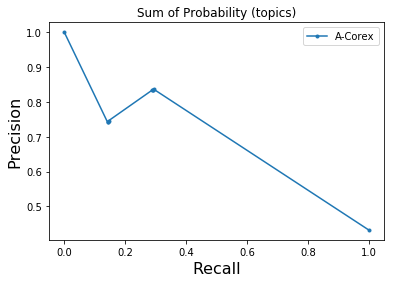

In [81]:
from matplotlib import pyplot
pyplot.plot(r1, p1, marker='.', label="A-Corex")

pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Sum of Probability (topics)')
pyplot.legend()
pyplot.show()

### ACorex: Precision vs Recall Plot - Sum of log Probabilities

In [15]:
p_y_x=anchored_topic_model.log_p_y_given_x
probability=p_y_x[:,0] + p_y_x[:,1]  
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p2, r2, th2 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

Text(0.5,1,'Sum of log Probability (topics)')

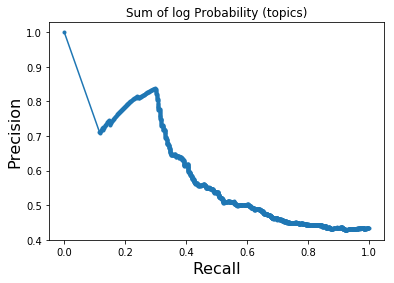

In [52]:
from matplotlib import pyplot
pyplot.plot(r2, p2, marker='.')
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Sum of log Probability (topics)')

### ACorex: Precision vs Recall Plot - Average of Probability

In [17]:
probability=(p_y_x[:,0] + p_y_x[:,1])/2
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p3, r3, th3 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

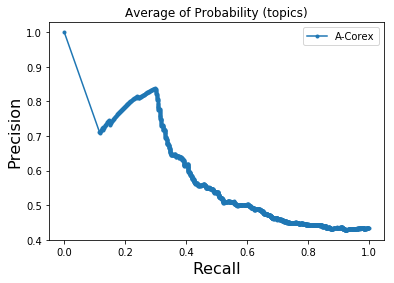

In [82]:
from matplotlib import pyplot
pyplot.plot(r3, p3, marker='.', label="A-Corex")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Average of Probability (topics)')
pyplot.legend()
pyplot.show()

### ACorex: Precision vs Recall Plot - Average of log Probability

In [19]:
probability=(p_y_x[:,0] + p_y_x[:,1])/2
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p4, r4, th4 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

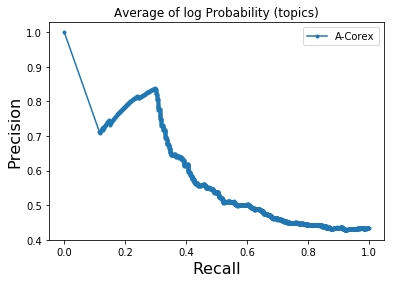

In [83]:
from matplotlib import pyplot
pyplot.plot(r4, p4, marker='.', label="A-Corex")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Average of log Probability (topics)')
pyplot.legend()
pyplot.show()

## More Anchor Words
    - earthquake: ~ምንቅጥቃጥ መሬት   (Romanized: meneqeteqaate mareete)
    - drought: ~ነቕጺ (Romanized: naqhetsi)
    - flood: ~ዕልቕልቕ (Romanized: eleqheleqhe)
    - disaster: መዓት; ~መቕዘፍቲ (Romanized: maaate; maqhezafeti)


In [21]:
anchor_words = [["መሬት"],["ሓደጋ","መዓት"],["ድርቂ" , "ድርቅን"],["ውሕጅ" ]]
anchored_topic_model = ct.Corex(n_hidden=4,max_iter=4000, seed=3192)   
anchored_topic_model.fit(doc_word_mat, words=words, anchors=anchor_words, anchor_strength=6);

In [22]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: እቲ,ከም,ናይ,ዘሎ,መሬት,ድማ,ስርዓት,ህዝቢ,እዚ,ግን
1: ሓደጋ,ውን,ኣሎ,ሃገራት,ኩሉ,ካልእ,ዓመታት,ሕጂ,ጥራይ,ነይሩ
2: ኣብ,ካብ,ናብ,ሓበሬታ,እዋን,ልዕሊ,እቶም,ድርቂ,መንግስቲ,ሃገር
3: ነቲ,ኣብዚ,ምስ,እዩ,ኣብቲ,ድሕሪ,ኮይኑ,ናይቲ,ክሳብ,ነዚ


In [23]:
p_y_x=anchored_topic_model.p_y_given_x
probability=p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3] 
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p5, r5, th5 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

### ACorex: Precision vs Recall Plot - Sum of Probability

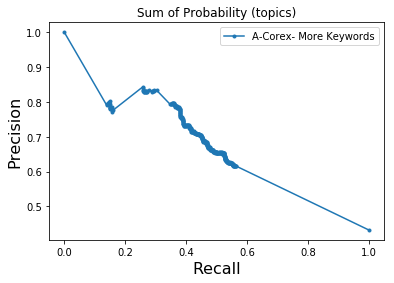

In [85]:
from matplotlib import pyplot
pyplot.plot(r5, p5, marker='.',  label="A-Corex- More Keywords")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Sum of Probability (topics)')
pyplot.legend()
pyplot.show()

### ACorex: Precision vs Recall Plot - Sum of log Probability

In [25]:
p_y_x=anchored_topic_model.log_p_y_given_x
probability=p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3] 
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p6, r6, th6 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

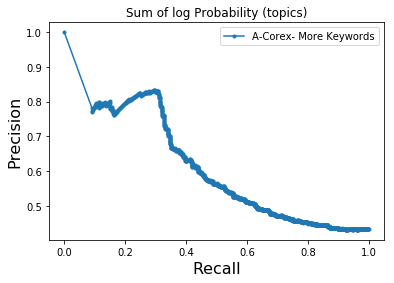

In [86]:
from matplotlib import pyplot
pyplot.plot(r6, p6, marker='.',  label="A-Corex- More Keywords")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Sum of log Probability (topics)')
pyplot.legend()
pyplot.show()

In [27]:
p_y_x=anchored_topic_model.p_y_given_x
probability=(p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3])/4
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p7, r7, th7 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

### ACorex: Precision vs Recall Plot - Mean of Probability

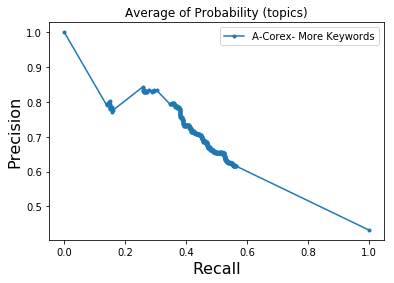

In [87]:
from matplotlib import pyplot
pyplot.plot(r7, p7, marker='.',  label="A-Corex- More Keywords")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Average of Probability (topics)')
pyplot.legend()
pyplot.show()

### ACorex: Precision vs Recall Plot - Average of log Probability

In [29]:
p_y_x=anchored_topic_model.log_p_y_given_x
probability=(p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3])/4
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p8, r8, th8 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

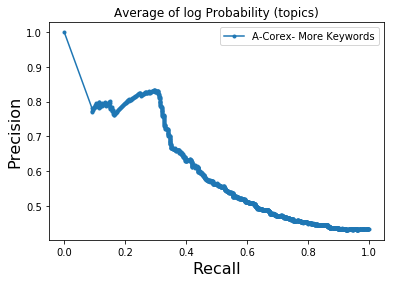

In [89]:
from matplotlib import pyplot
pyplot.plot(r8, p8, marker='.',  label="A-Corex- More Keywords")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Average of log Probability (topics)')
pyplot.legend()
pyplot.show()

### Guided-LDA

In [31]:
model3 = guidedlda.GuidedLDA(n_topics=4, n_iter=4000, random_state=7, refresh=20)

### Document-Term Matrix-(count matrix)

In [32]:
vectorizer2 = CountVectorizer(encoding='utf-8',stop_words=None,max_df=0.997, min_df=0.001, binary=False,lowercase=False)
doc_word_mat2 = vectorizer2.fit_transform(reset_data.text_data)
doc_word_mat2 = doc_word_mat2.toarray()
words2 = list(np.asarray(vectorizer2.get_feature_names()))
word2id = dict((v, idx) for idx, v in enumerate(words2))

In [33]:
seed_topic_list = [["መሬት"],["ሓደጋ","መዓት"],["ድርቂ" , "ድርቅን"],["ውሕጅ" ]]
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [34]:
model3.fit(doc_word_mat2, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 4573
INFO:guidedlda:vocab_size: 6737
INFO:guidedlda:n_words: 223793
INFO:guidedlda:n_topics: 4
INFO:guidedlda:n_iter: 4000
INFO:guidedlda:<0> log likelihood: -2139849
INFO:guidedlda:<20> log likelihood: -1784087
INFO:guidedlda:<40> log likelihood: -1733621
INFO:guidedlda:<60> log likelihood: -1713776
INFO:guidedlda:<80> log likelihood: -1706509
INFO:guidedlda:<100> log likelihood: -1703203
INFO:guidedlda:<120> log likelihood: -1701246
INFO:guidedlda:<140> log likelihood: -1700504
INFO:guidedlda:<160> log likelihood: -1699567
INFO:guidedlda:<180> log likelihood: -1698762
INFO:guidedlda:<200> log likelihood: -1697487
INFO:guidedlda:<220> log likelihood: -1697078
INFO:guidedlda:<240> log likelihood: -1697129
INFO:guidedlda:<260> log likelihood: -1696347
INFO:guidedlda:<280> log likelihood: -1696062
INFO:guidedlda:<300> log likelihood: -1696050
INFO:guidedlda:<320> log likelihood: -1695540
INFO:guidedlda:<340> log likelihood: -1695178
INFO:guidedlda:<360> log li

INFO:guidedlda:<3420> log likelihood: -1692845
INFO:guidedlda:<3440> log likelihood: -1693010
INFO:guidedlda:<3460> log likelihood: -1692838
INFO:guidedlda:<3480> log likelihood: -1692372
INFO:guidedlda:<3500> log likelihood: -1693001
INFO:guidedlda:<3520> log likelihood: -1692432
INFO:guidedlda:<3540> log likelihood: -1692924
INFO:guidedlda:<3560> log likelihood: -1692505
INFO:guidedlda:<3580> log likelihood: -1692927
INFO:guidedlda:<3600> log likelihood: -1692357
INFO:guidedlda:<3620> log likelihood: -1692806
INFO:guidedlda:<3640> log likelihood: -1692752
INFO:guidedlda:<3660> log likelihood: -1692174
INFO:guidedlda:<3680> log likelihood: -1692832
INFO:guidedlda:<3700> log likelihood: -1693468
INFO:guidedlda:<3720> log likelihood: -1692625
INFO:guidedlda:<3740> log likelihood: -1693027
INFO:guidedlda:<3760> log likelihood: -1692724
INFO:guidedlda:<3780> log likelihood: -1692684
INFO:guidedlda:<3800> log likelihood: -1692976
INFO:guidedlda:<3820> log likelihood: -1693302
INFO:guidedld

In [35]:
p_y_x = model3.doc_topic_
probability=p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3]
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p9, r9 ,th9 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

### G-LDA: Precision vs Recall Plot - Sum of Probability

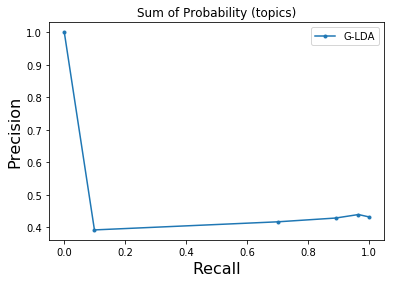

In [90]:
from matplotlib import pyplot
pyplot.plot(r9, p9, marker='.',label="G-LDA")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Sum of Probability (topics)')
pyplot.legend()
pyplot.show()

In [60]:
p_y_x = model3.doc_topic_
probability=(p_y_x[:,0] + p_y_x[:,1] + p_y_x[:,2] + p_y_x[:,3])/4
probability=pd.Series(probability)
labels=reset_data.class_type
df = pd.concat([probability, labels], axis=1)
df.columns = ['probability','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p10, r10, th10 = precision_recall_curve(df.label, df.probability,pos_label="indomain")

In [38]:
### G-LDA : Precision vs Recall Plot - Mean of Probability

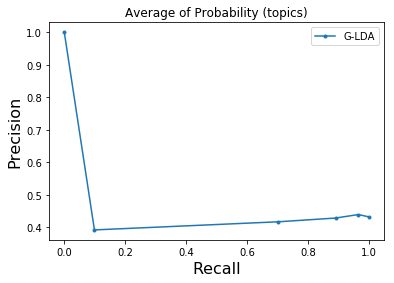

In [91]:
from matplotlib import pyplot
pyplot.plot(r10, p10, marker='.',label="G-LDA")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Average of Probability (topics)')
pyplot.legend()
pyplot.show()

### Combined: Precision vs Recall Plot - Sum of Probability

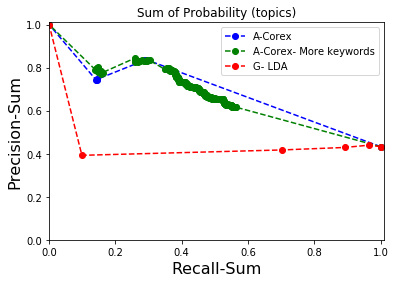

In [98]:
## combined graph
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(r1, p1, 'bo',linestyle='--',label='A-Corex')
plt.plot(r5, p5, 'go',linestyle='--',label='A-Corex- More keywords')
plt.plot(r9, p9, 'ro',linestyle='--',label='G- LDA')
plt.xlabel('Recall-Sum', fontsize=16)
plt.ylabel('Precision-Sum', fontsize=16)
plt.title('Sum of Probability (topics)')
plt.legend()
plt.show()

### Combined: Precision vs Recall Plot - Sum of log Probability

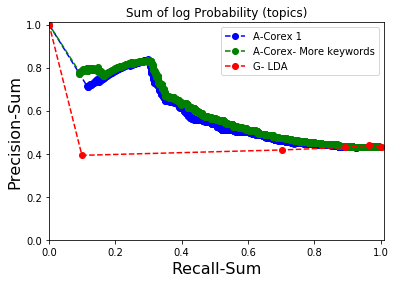

In [99]:
## combined graph
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(r2, p2, 'bo',linestyle='--',label='A-Corex 1')
plt.plot(r6, p6, 'go',linestyle='--',label='A-Corex- More keywords')
plt.plot(r9, p9, 'ro',linestyle='--',label='G- LDA')
plt.xlabel('Recall-Sum', fontsize=16)
plt.ylabel('Precision-Sum', fontsize=16)
plt.title('Sum of log Probability (topics)')
plt.legend()
plt.show()

### Combined: Precision vs Recall Plot - Mean of Probability

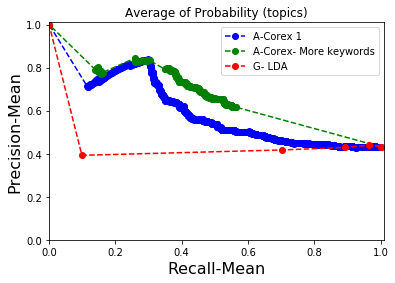

In [100]:
## combined graph
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(r3, p3, 'bo',linestyle='--',label='A-Corex 1')
plt.plot(r7, p7, 'go',linestyle='--',label='A-Corex- More keywords')
plt.plot(r10, p10, 'ro',linestyle='--',label='G- LDA')
plt.xlabel('Recall-Mean', fontsize=16)
plt.ylabel('Precision-Mean', fontsize=16)
plt.title('Average of Probability (topics)')
plt.legend()
plt.show()

### Combined: Precision vs Recall Plot - Average of log Probability

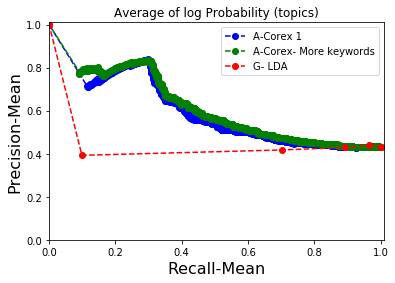

In [101]:
## combined graph
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(r4, p4, 'bo',linestyle='--',label='A-Corex 1')
plt.plot(r8, p8, 'go',linestyle='--',label='A-Corex- More keywords')
plt.plot(r10, p10, 'ro',linestyle='--',label='G- LDA')
plt.xlabel('Recall-Mean', fontsize=16)
plt.ylabel('Precision-Mean', fontsize=16)
plt.title('Average of log Probability (topics)')
plt.legend()
plt.show()

In [44]:
vectorizer = TfidfVectorizer(encoding='utf-8',stop_words=None, max_df =0.995, min_df = 0.001,binary =False,
                             lowercase=True, use_idf=True,smooth_idf=True)

tf_idf_mat = vectorizer.fit_transform(reset_data.text_data)
tf_idf_mat.shape # n_docs x m_words

(4573, 6768)

In [45]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [46]:
tf_idf_mat = tf_idf_mat.todense()

In [47]:
key_words = ["መሬት","ሓደጋ","መዓት","ድርቂ","ድርቅን","ውሕጅ" ]
indices =np.isin(words, key_words, assume_unique=True, invert=False).nonzero()[0]

In [48]:
keyword_mat=tf_idf_mat[:,indices]
tf_idf = pd.DataFrame(keyword_mat)
tf_idf = tf_idf.apply(sum, axis=1)

In [49]:
tf_idf = pd.Series(tf_idf)
labels = reset_data.class_type
df = pd.concat([tf_idf, labels], axis=1)
df.columns = ['tf_idf','label']
# filter unknown class
df = df.loc[df.label !="unk"]
p11, r11, th11 = precision_recall_curve(df.label, df.tf_idf,pos_label="indomain")

### TF-IDF: Precision vs Recall Plot

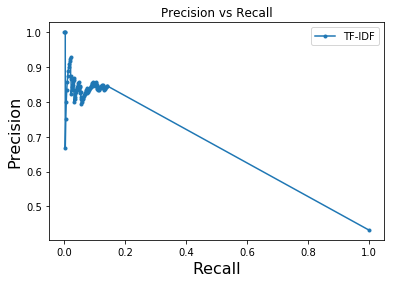

In [104]:
from matplotlib import pyplot
pyplot.plot(r11, p11, marker='.', label="TF-IDF")
pyplot.xlabel('Recall', fontsize=16)
pyplot.ylabel('Precision', fontsize=16)
pyplot.title('Precision vs Recall')
pyplot.legend()
pyplot.show()
